In [1]:
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using Parameters
using StaticArrays
using ProfileView

using GridInterpolations 
using POMDPs
using POMDPToolbox
using QMDP
using JLD
using Reel
using Revise


include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")
include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")
include("../src/pedestrian_crossing/helpers.jl")



animate_record (generic function with 2 methods)

In [5]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")
include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")
include("../src/pedestrian_crossing/helpers.jl")



qmdp_policy = load("policy.jld")["policy"];


pomdp = SingleOCFPOMDP()
updater = SingleOCFUpdater(pomdp)

params = CrosswalkParams()
params.obstacles_visible = false

obstacle_1 = ConvexPolygon([VecE2(34, -1.5), VecE2(34, -4.5), VecE2(46.5, -4.5), VecE2(46.5, -1.5)],4)
obstacle_2 = ConvexPolygon([VecE2(34, +4.5), VecE2(34, +7.5), VecE2(46.5, +7.5), VecE2(46.5, +4.5)],4)
params.obstacles = [obstacle_1, obstacle_2]
#params.obstacles = [obstacle_2]

env = CrosswalkEnv(params)
pomdp.env = env


ego_id = 1
ped_id = 2
ped2_id = 3


ego_v = 11.11
ped_v = 5.4/3.6
hitpoint = 0             # 50: middle, 100: left corner, 0: right corner
ped_theta = π/2


# fix values
ped_x = 50.0
ped_y_start = -7.0
ego_y = 0.0


ped_y_offset_hitpoint = VehicleDef().width * hitpoint / 100 - VehicleDef().width/2
ped_y_end = ped_y_offset_hitpoint
ped_t_collision = (ped_y_end - ped_y_start) / ped_v; 
ego_x = ped_x - ego_v * ped_t_collision - VehicleDef().length/2;

if ( false )
    ego_v = 0.0
    ego_x = 20
    ped_x = 30
    ped_y_start = -2.0
    ped_v = 0.0
end

ped_y_start = -5.0
ped_v = 1.0

# Car definition
ego_initial_state = VehicleState(VecSE2(ego_x, ego_y, 0.), env.roadway.segments[1].lanes[1], env.roadway, ego_v)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

# Pedestrian definition 
ped_initial_state = VehicleState(VecSE2(ped_x,ped_y_start,ped_theta), env.crosswalk, env.roadway, ped_v)
ped = Vehicle(ped_initial_state, AutomotivePOMDPs.PEDESTRIAN_DEF, 2)

ped2_v = 2.0
ped2 = Vehicle(VehicleState(VecSE2(54., 3., 1.57), env.crosswalk, env.roadway, ped2_v), AutomotivePOMDPs.PEDESTRIAN_DEF, ped2_id)


scene = Scene()
push!(scene, ego)
push!(scene, ped)
push!(scene, ped2)



cam = FitToContentCamera(0.);
timestep = 0.2


pos_noise = 0.001
vel_noise = 0.001
false_positive_rate = 0.00
false_negative_rate = 0.00
rng = MersenneTwister(1);
sensor = AutomotiveSensors.GaussianSensor(AutomotiveSensors.LinearNoise(10, pos_noise, 0.00), 
                 AutomotiveSensors.LinearNoise(10, vel_noise, 0.00), false_positive_rate, false_negative_rate, rng) 



# define a model for each entities present in the scene
models = Dict{Int, DriverModel}()


obs = SingleOCFState(0.0, ego_v, ped_x-ego_x, ped_y_start, ped_theta, ped_v)
println(obs)

pomdp.ego_vehicle = ego
models[ego_id] = FrenetPedestrianPOMDP(a=LatLonAccel(0.0, 0.0),env=env,sensor=sensor, obstacles=env.obstacles, timestep=timestep,
    env=env,
    pomdp=pomdp,
    policy=qmdp_policy,
    updater=updater,
    ego_vehicle=ego,
    desired_velocity=ego_v,
    b=initBeliefAbsentPedestrian(pomdp, ego_y, ego_v)
)
models[ego_id].pomdp.desired_velocity = ego_v
models[ego_id].pomdp.ΔT = timestep

models[ped_id] = ConstantPedestrian(v_desired=ped.state.v, dawdling_amp=0.001) # dumb model
models[ped2_id] = ConstantPedestrian(v_desired=ped2.state.v, dawdling_amp=0.001) # dumb model


nticks = 25
rec = SceneRecord(nticks+1, timestep)

risk = Float64[]
sensor_observations = [Vehicle[]]
belief = Dict{Int64, SingleOCFBelief}[]
ego_vehicle = Vehicle[]
action_pomdp = SingleOCFAction[]

obs_callback = (ObservationCallback(risk,sensor_observations, belief, ego_vehicle, action_pomdp),)

tic()
simulate!(rec, scene, env.roadway, models, nticks, obs_callback)
toc()




SingleOCFState(0.0, 11.11, 47.18066666666666, -5.0, 1.5707963267948966, 1.0)
--------------------------POMDP high level planner----------------------- t: 0.0
EGO: x/y:2.81933333333334 / 0.0 v: 11.11
Dict(-1=>SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0))
Pedestrian is absent: SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0)
ego_v_state_space: 11.0
--------------------------POMDP high level planner----------------------- t: 0.2
EGO: x/y:5.041333333333339 / 0.0 v: 11.11
Dict(2=>SingleOCFState(0.0, 11.11, 44.959, -4.79942, 1.5708, 1.00096),3=>SingleOCFState(0.0, 11.11, 48.9581, 3.40041, 1.57, 1.99995),-1=>SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0))
ped appeard
Pedestrian is visible: SingleOCFState(0.0, 11.11, 44.95898219959555, -4.799416291712431, 1.5707963267948966, 1.0009632716050383)
ego_v_state_space: 11.0
ped appeard
Pedestrian is visible: SingleOCFState(0.0, 11.11, 48.95814432990924, 3.4004076514786203, 1.5700000000000003, 1.9999495487700663)
ego_v_state_space: 11.0
new 

Pedestrian is absent: SingleOCFState(0.0, 9.0, -10.0, -10.0, 0.0, 0.0)
ego_v_state_space: 9.0
action before update: SingleOCFAction(-1.0, 0.0)
action after update: SingleOCFAction(-1.0, 0.0)
--------------------------POMDP high level planner----------------------- t: 2.6
EGO: x/y:28.825333333333354 / 0.0 v: 8.710000000000008
Dict(2=>SingleOCFState(0.0, 8.71, 21.176, -2.89913, 1.5708, 0.498475),-1=>SingleOCFState(0.0, 9.0, -10.0, -10.0, 0.0, 0.0))
Pedestrian is visible: SingleOCFState(0.0, 8.710000000000008, 21.17603800039142, -2.899134640965492, 1.5707963267948966, 0.49847511317901105)
ego_v_state_space: 9.0
Pedestrian is absent: SingleOCFState(0.0, 9.0, -10.0, -10.0, 0.0, 0.0)
ego_v_state_space: 9.0
action before update: SingleOCFAction(-1.0, 0.0)
action after update: SingleOCFAction(-1.0, 0.0)
--------------------------POMDP high level planner----------------------- t: 2.8000000000000003
EGO: x/y:30.547333333333356 / 0.0 v: 8.510000000000009
Dict(2=>SingleOCFState(0.0, 8.51, 19.4565,

9.610063418

In [6]:
duration, fps, render_hist = animate_record(rec, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, CarFollowCamera(2,20.0))
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpNPVtea", 0x000000000000001a, 5.0, nothing)

In [4]:
n_states(pomdp)

107251

2=>POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 10.0, 2.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, 0.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, 0.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, -2.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, -1.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 0.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 2.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 2.0, 0.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 2.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 2.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 2.0, 0.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 4.0, -2.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 4.0, -1.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 4.0, 0.0, 1.57, 0.5), SingleOCFState(0.0, 10.0, 2.0, -2.0, 1.57

2

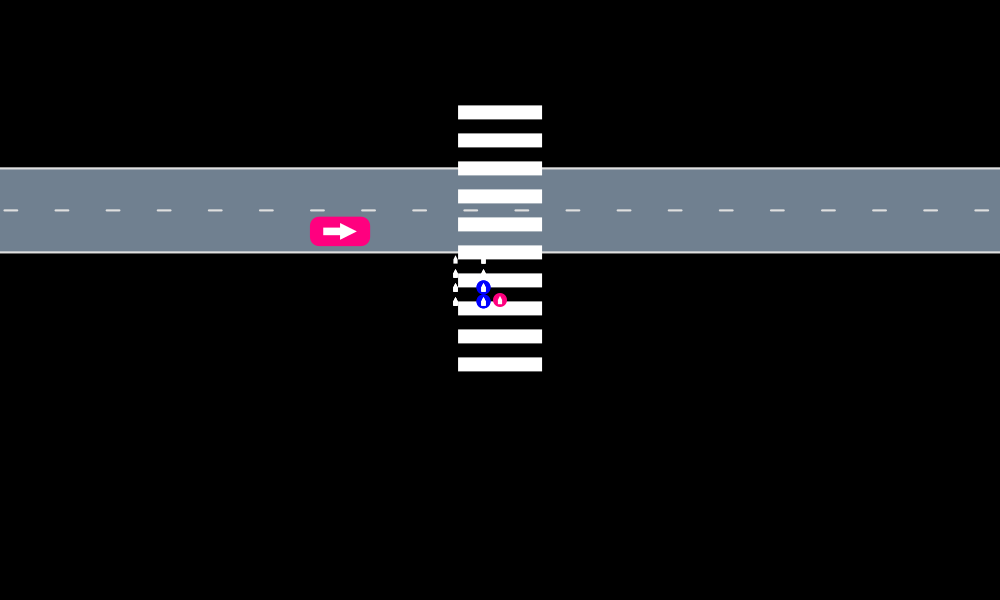

In [71]:
i = 3
scene = rec[0]
bel = belief[i]
belief_overlay = BeliefOverlay(belief=bel, ego_vehicle=ego_vehicle[i])

AutoViz.render(rec[-1], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

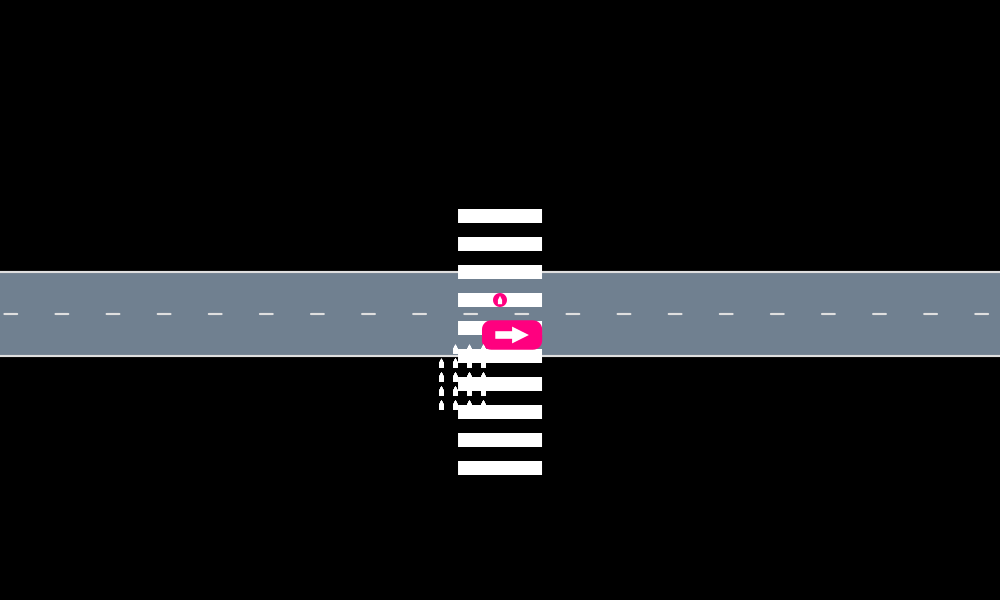

In [31]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")
include("../src/pedestrian_crossing/helpers.jl")


include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")

next_states = SingleOCFState[]
for (s, prob) in weighted_iterator(bel)
    td = transition(pomdp, s, SingleOCFAction(-2.0, 0.0), pomdp.ΔT)
    for sp in td.vals
        push!(next_states, sp)
    end
end
pred_bel = SparseCat(next_states, normalize(ones(length(next_states)),1))
belief_overlay = BeliefOverlay(belief=pred_bel, ego_vehicle=ego_vehicle[i])
fake_ego = VehicleState()
scene = Scene()
AutoViz.render(rec[0], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

In [46]:
pomdp

SingleOCFPOMDP
  env: AutomotivePOMDPs.CrosswalkEnv
  ego_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  longitudinal_actions: Array{Float64}((5,)) [1.0, 0.0, -1.0, -2.0, -4.0]
  lateral_actions: Array{Float64}((3,)) [1.0, 0.0, -1.0]
  ΔT: Float64 0.5
  PED_A_RANGE: Array{Float64}((5,)) [-2.0, -1.0, 0.0, 1.0, 2.0]
  PED_THETA_NOISE: Array{Float64}((3,)) [-0.195, 0.0, 0.195]
  PED_SAFETY_DISTANCE: Float64 1.0
  EGO_Y_MIN: Float64 -1.0
  EGO_Y_MAX: Float64 1.0
  EGO_Y_RANGE: Array{Float64}((1,)) [0.0]
  EGO_V_MIN: Float64 0.0
  EGO_V_MAX: Float64 14.0
  EGO_V_RANGE: Array{Float64}((29,)) [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0]
  S_MIN: Float64 0.0
  S_MAX: Float64 50.0
  S_RANGE: Array{Float64}((51,)) [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0]
  T_MIN: Float64 -5.0
  T_MAX: Float64 5.0
  T_RANGE: Array{F

In [55]:
pomdp.env.params.obstacles_visible

false

is_observation_absent (generic function with 1 method)

SingleOCFState(-1.0, 14.0, -10.0, -10.0, 0.0, 0.0)

In [119]:
s = SingleOCFState(0.0, 10.5, -10.0, -10.0, 0.0, 0.0)
a = SingleOCFAction(-4.0, 0.0)
td = transition(pomdp, s, a) 


absent_state_present = false
for (s, prob) in weighted_iterator(td)
    if is_state_absent(pomdp, s) 
       absent_state_present = true 
    end
    cnt += 1
end


SingleOCFState(0.0, 9.5, -10.0, -10.0, 0.0, 0.0)


LoadError: [91msyntax: unexpected "end"[39m

In [191]:
b = POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 9.0, -10.0, -10.0, 0.0, 0.0)], [1.0])
a = SingleOCFAction(-4.0, 0.0)
o = SingleOCFState(0.0, 8.329999999999998, 21.32259231837015, -4.899329938018746, 1.5707963267948966, 2.5005508523775006)

(ego_y_state_space, ego_v_state_space) = getEgoDataInStateSpace(pomdp, o.ego_y, o.ego_v)

sp = get_state_absent(pomdp, ego_y_state_space, ego_v_state_space)
sp = SingleOCFState(0.0, 0.0, 21.0, -5.0, 1.57, 2)
po = observation_weight(pomdp, sp, o) 


0.040455258340222476

0.040455258340222476

In [228]:
length(bel)

136

In [36]:
n_states(pomdp)

1451451

In [12]:
FrenetPedestrianPOMDP(a=LatLonAccel(0.0, 0.0),env=env,sensor=sensor, obstacles=env.obstacles, timestep=timestep)

LoadError: [91mTypeError: Type: in parameter, expected Type, got Array{Int64,1}[39m

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:430


In [12]:
belief[16][3]

POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 10.0, 2.0, 4.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, 5.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, 5.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 4.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 4.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 0.0), SingleOCFState(0.0, 10.0, 2.0, 4.0, 1.57, 0.5)  …  SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 1.5), SingleOCFState(0.0, 10.0, 2.0, 4.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 2.0, 5.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 2.0, 5.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 4.0, 4.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 4.0, 4.0, 1.57, 2.0), SingleOCFState(0.0, 10.0, 4.0, 5.0, 1.57, 2.0), Singl

true

In [170]:
 b = POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0)], [1.0])

POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0)], [1.0])

In [171]:
b

POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0)], [1.0])

In [180]:
b = weighted_iterator(b)

POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}(SingleOCFState[SingleOCFState(0.0, 11.0, -10.0, -10.0, 0.0, 0.0)], [1.0])

bingo


In [182]:
b[1]

LoadError: [91mMethodError: no method matching getindex(::POMDPToolbox.SparseCat{Array{SingleOCFState,1},Array{Float64,1}}, ::Int64)[39m